# Advanced AI for Business Applications 
## Recurrent Neural Network (RNN)

#### Resources and references from MSBA 6461, Spring 2024, Mochen Yang   
Professor's GitHub link: https://github.com/mochenyang/MSBA6460-Advanced-AI.git

# Table of contents
1. [Setup](#setup)
1. [Basic RNN Model](#basic_rnn)
    - [Why Use RNN for Language-Related Machine Learning Tasks?](#basic_rnn_motivation)
    - [Common RNN Architectures for NLP](#basic_rnn_architecture)
    - [Animated Illustration of a Simple RNN Unit](#basic_rnn_figure)
    - [How does a Simple RNN Unit work?](#basic_rnn_tech)
    - [Build Simple RNN in Keras](#basic_rnn_implement)
1. [The Long-Term Dependency Problem](#dependency)
1. [LSTM Model](#lstm)
    - [Animated Illustration of a Single LSTM Unit](#lstm_figure)
    - [How does a Single LSTM Unit/Cell Work?](#lstm_tech)
    - [Build RNN with LSTM Units in Keras](#lstm_implementation)
1. [GRU Model](#gru)
    - [Animated Illustration of a Single GRU](#gru_figure)
    - [How does a Single GRU Work?](#gru_tech)
    - [Build RNN with GRUs in Keras](#gru_implementation)
1. [Bidirectional RNN Models](#birnn)
    - [Building Bidirectional RNN Model in Keras](#birnn_implementation)
1. [Additional Resources](#resources)

# Setup: Import Data and Preprocess Text <a name="setup"></a>

In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

We will use a [sentiment classification dataset on UCI](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). Download this dataset and import it. Create two numpy arrays to store the texts and labels separately.

In [13]:
text = []
label = []
for line in open('sentiment.txt', encoding='utf-8'):
    line = line.rstrip('\n').split('\t')
    text.append(line[0])
    label.append(int(line[1]))
text = np.array(text)
label = np.array(label)

# to fix 'cp950' codec can't decode byte 0xc2 in position 2444: illegal multibyte sequence, 
# add encoding='utf-8' in the open() func. 

Here we use the `TextVectorization()` function in `keras` to complete basic text processing tasks. See the function documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization). 

In particular, you can control the following things:
- tokenization (split)
- lowercasing and remove puctuation (standardize)
- optionally generate ngrams
- turn into integer representation (output_mode = 'int')
- whether to pad texts of different length to the same sequence length (output_sequence_length)

In [14]:
vectorize_layer = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = None,
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = None
)

In [15]:
# apply it to the text data with "adapt"
vectorize_layer.adapt(text)

# vocabulary: optional argument in TextVectorization(), can pass either an array of strings or a string path to a text file. 
# Note that if this argument is set, there is no need to adapt() the layer.

# Calling adapt() on a TextVectorization layer is an alternative to passing in a precomputed vocabulary on construction via the vocabulary argument.
# A TextVectorization layer should always be either adapted over a dataset or supplied with a vocabulary.
# During adapt(), the layer will build a vocabulary of all string tokens seen in the dataset, sorted by occurrence count, with ties broken by sort order of the tokens (high to low).

In [16]:
# check preprocessing results, such as vocabulary, 
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'i',
 'a',
 'is',
 'to',
 'it',
 'this',
 'of',
 'was',
 'in',
 'for',
 'not',
 'that',
 'with',
 'my',
 'very',
 'good',
 'on',
 'great',
 'you',
 'but',
 'have',
 'are',
 'movie',
 'as',
 'so',
 'phone',
 'film',
 'its',
 'be',
 'all',
 'one',
 'had',
 'at',
 'food',
 'like',
 'just',
 'place',
 'time',
 'were',
 'service',
 'an',
 'really',
 'if',
 'from',
 'there',
 'they',
 'bad',
 'we',
 'well',
 'out',
 'has',
 'dont',
 'about',
 'would',
 'your',
 'or',
 'no',
 'only',
 'by',
 'best',
 'ever',
 'even',
 'here',
 'also',
 'will',
 'back',
 'up',
 'when',
 'me',
 'than',
 'more',
 'quality',
 'go',
 'what',
 'love',
 'ive',
 'which',
 'made',
 'he',
 'can',
 'because',
 'product',
 'im',
 'how',
 'too',
 'get',
 'work',
 'their',
 'some',
 'works',
 'nice',
 'could',
 'better',
 'any',
 'excellent',
 'after',
 'never',
 'do',
 'recommend',
 'much',
 'been',
 'who',
 'use',
 'our',
 'did',
 'again',
 'sound',
 'other',
 'think',
 'his',
 'headset',


In [17]:
len(vectorize_layer.get_vocabulary())

5404

Note that the vocabulary contains two special tokens:
- '' is called the **padding token**. It is an empty string, correspond to index 0, that can be used to pad texts of different lengths to the same sequence length. When this text vectorization layer is applied to a set of texts, it automatically perform padding (to the longest sequence).
- '[UNK]' is called the **Out-of-Vocabulary token**. It is used to represent any word that does not appear in the vocabulary.

The next block of code is for demonstration purpose only - it is typically NOT needed in actual model building.   
We want to use `vectorize_layer` to process some texts and represent them as indices in vocabulary.

In [18]:
# now use it to process some text
input_text = [['very good movie'], ['Mochen Yang']]
vectorize_layer(input_text) 

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[18, 19, 26],
       [ 1,  1,  0]], dtype=int64)>

# Basic RNN Model <a name="basic_rnn"></a>

## Why Use RNN for Language-Related Machine Learning Tasks? <a name="basic_rnn_motivation"></a>

1. Natural language is a sequence (of words). RNNs are specifically designed to handle **sequential data**;
2. It is easy to use word embeddings as inputs to RNNs, further boosting the ability to incorporate semantic information;
3. Different pieces of texts can have different lengths. RNNs are built to deal with **variable-length data (via parameter sharing** - discussed later);
4. Different NLP tasks require different network architectures. **RNNs are versatile enough* to accommodate those.

## Common RNN Architectures for NLP <a name="basic_rnn_architecture"></a>

### Many Inputs, One Output

- **Suitable Task**: Classification and Numeric Prediction
- **Typical Architecture** is discussed and demonstrated in this notebook.


### Many Inputs, Many Outputs

- **Suitable Tasks**:
    - Machine Translation
    - Document Summarization
    - Conversational Model (Q&A, Chatbot, etc.)
- **Typical Architecture**: encoder-decoder architecture (discussed in a different notebook).

## Animated Illustration of a Simple RNN Unit <a name="basic_rnn_figure"></a>

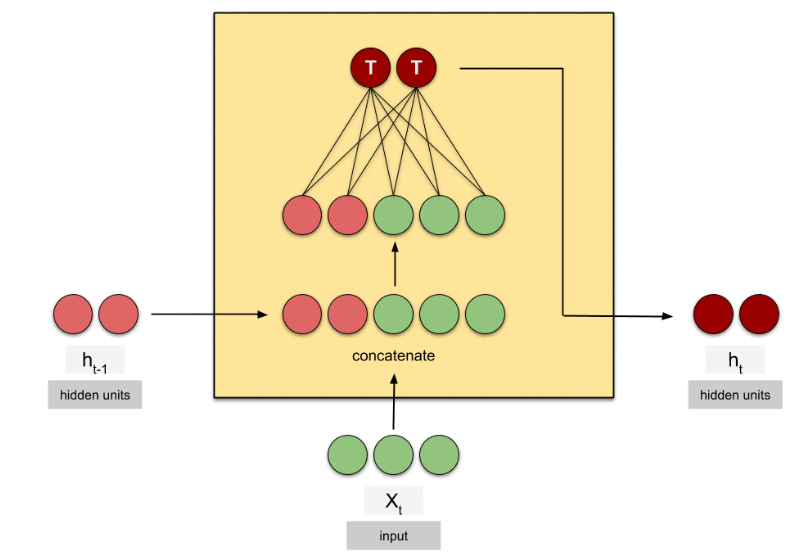

**<font color='blue'>
h_t = f(h_t-1, X_t, W) = f([h_t-1, X_t]*W)
W doesn't have t sign >> parameter sharing</font>**

image credit: https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45

## How does a Simple RNN Unit work? <a name="basic_rnn_tech"></a>
The inner workings of a simple RNN unit can be represented either as a recurrent equation:

$$h_{t} = f(h_{t-1}, X_{t}, \Theta)$$

- $h_{t}$ is the hidden states at time step $t$;
- $X_{t}$ is the input (usually a vector) at time step $t$;
- $\Theta$ is (usually matrices) of weights to be learned. <font color='red'>Notice that $\Theta$ does not have any subscript, which means that it is the same set of parameters for **every time step $t$**. This is the key idea of **parameter sharing**!</font> Without parameter sharing, RNNs would not be able to handle texts of different lengths.
- $f()$ is the activation function that governs how past states ($h_{t-1}$) combine with current information ($X_{t}$) to determine current states of the network. Typically this is the hyperbolic tangent $tanh$ function (see [here](https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions) for technical definition).

**Importantly**, the recurrent relationship discussed here is a universal signature of RNNs. <font color='blue'> Even for more complex types of RNNs, we are still trying to characterize how the hidden states at time t-1, combined with input received at time t, jointly determine the hidden states at time t </font>. In the context of NLP, you can conceptually think of this recurrent relationship as a "reading" process: the neural network is reading a piece of text word by word, and its hidden states are "updated" after the ingestion of every word.

## Build Simple RNN in Keras <a name="basic_rnn_implement"></a>

Now, let's actually build a basic RNN model, by stacking together the text processing layer, an embedding layer, and an RNN layer. Documentation to RNN layer is [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN).

In [20]:
model_rnn = keras.Sequential()

model_rnn.add(vectorize_layer) # text processing 

# there's no focal/context words process >> so we're not using the technique learned before 
# this is end-to-end training >> start with the raw input, train weights and the downstreaming tasks together, the task is viewed as a part of the training materials 
# end-to-end training example: self-driving car
# end-to-end is contrast to "pre-training" >> train the model regardless of the downstreaming tasks 

model_rnn.add(keras.layers.Embedding( # embedding layer 
    input_dim = len(vectorize_layer.get_vocabulary()), 
    output_dim = 64, # dimension of the dense embedding
    mask_zero = True 
    # whether or not the input value 0 is a special "padding" value that should be masked out. 
    # This is useful when using recurrent layers which may take variable length input.
))

model_rnn.add(keras.layers.SimpleRNN(128)) # see note below

model_rnn.add(keras.layers.Dense(1, activation = 'sigmoid'))

For classification task, because we only need a single output at the end of the entire RNN, you only need to specify the total number of RNN units in the `SimpleRNN` function. You might be wondering - don't we need the input_size parameter? It is not necessary here because the preceding embedding layer automatically informs the RNN layer that each input text will have variable length (padded with special value 0 to max sequence length, and padding value 0 is automatically masked) and each word is represented by 64 dimensions in this example (i.e., the output dimension of the word embedding).

<font color = "red">Question: Looking at the embedding layer, which method is it using to train the word embeddings (e.g., skip-gram, continuous bag-of-words, both, neither)?</font> This method/strategy of training a neural network model is known as **end-to-end training**.

In [21]:
# configure training / optimization
model_rnn.compile(loss = keras.losses.BinaryCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])

In [26]:
text.dtype

dtype('<U479')

In [25]:
label.dtype

dtype('int32')

In [22]:
# training with 20% validation and 10 epochs.
model_rnn.fit(x = text, y = label, validation_split = 0.2,
              epochs=10, batch_size = 32)

Epoch 1/10
75/75 [==============================] - 3s 19ms/step - loss: 0.6875 - accuracy: 0.5525 - val_loss: 0.6810 - val_accuracy: 0.5583
Epoch 2/10
75/75 [==============================] - 1s 15ms/step - loss: 0.5082 - accuracy: 0.8321 - val_loss: 0.6023 - val_accuracy: 0.6883
Epoch 3/10
75/75 [==============================] - 1s 15ms/step - loss: 0.2006 - accuracy: 0.9463 - val_loss: 0.5786 - val_accuracy: 0.7583
Epoch 4/10
75/75 [==============================] - 1s 15ms/step - loss: 0.0858 - accuracy: 0.9787 - val_loss: 0.7411 - val_accuracy: 0.7267
Epoch 5/10
75/75 [==============================] - 1s 18ms/step - loss: 0.0384 - accuracy: 0.9942 - val_loss: 0.6512 - val_accuracy: 0.7900
Epoch 6/10
75/75 [==============================] - 1s 15ms/step - loss: 0.0154 - accuracy: 0.9987 - val_loss: 0.7076 - val_accuracy: 0.7717
Epoch 7/10
75/75 [==============================] - 1s 16ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.7510 - val_accuracy: 0.7783
Epoch 8/10
75

In [15]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          345856    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               24704     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 370,689
Trainable params: 370,689
Non-trainable params: 0
_________________________________________________________________


In [10]:
5404*64 # 5404 unique words 

345856

In [3]:
(64+128+1)*128 # +1 is ti add the bias term 

24704

In [ ]:
# Total params: 370,689
# Trainable params: 370,689 
# the total parameters trained is much more than the amount of input data >> we don't know why it work so well 

In [14]:
# try to make some predicitons
model_rnn.predict([['I hate this meal!'], ['I love this restaurant']])

array([[0.03613052],
       [0.999736  ]], dtype=float32)

# The Long-Term Dependency Problem <a name="dependency"></a>

## So Why Do We Need Anything More than Simple RNN?

As the training process continuing, the model starts to "forget" what we have learned in the earlier steps.   
That is, the model is not able to retain the information obtaining earlier as the training progresses. 

Here is a highly simplified (non-rigorous) derivation to help you understand. Suppose there is only 1 parameter, $w$, to learn, and the activitaion function, $f()$, is linear, and there is a constant input value of 0. Considering realistic inputs, non-linear activiation functions, and parameter matrices would make the derivation too hard to track but the underlying intuitions are the same. 

Think about how the hidden states of an RNN unit change over time:
$$h_{t} = w \cdot h_{t-1}$$
in other words,
$$h_{t} = w^t \cdot h_0$$
Now, the gradient of $h_t$ with respect to parameter $w$ is
$$\frac{dh_t}{dw} = tw^{t-1} h_0$$

For a long sequence (i.e., $t$ is large), the **gradient will explode** (go to $\infty$) even if $w$ is just slightly larger than 1, and the **gradient will vanish** (go to 0) even if $w$ is just slightly smaller than 1. This makes training RNN to learn from long sequences very hard. If the gradient is extremely large, gradient descent with any regular learning rate will be highly unstable. If the gradient is extremely small, gradient descent won't "descent" much at all.

<font color='red'>Question: is this a problem for traditional, feed-forward neural networks with many hidden layers? If not, why not?</font>

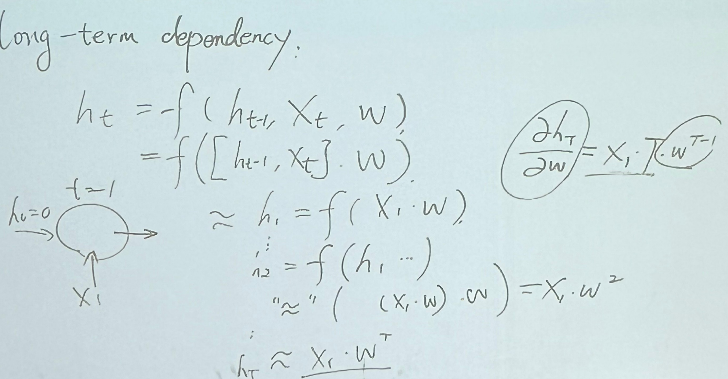

<font color='red'>1. The problematic gradient is on the RHS, where w^T-1 can explode or vanish</font>  
<font color='red'>2. The approximation "~~" is identity function</font>

# Long Short-Term Memory (LSTM) Model <a name="lstm"></a>

## Animated Illustration of a Single LSTM Unit <a name="lstm_figure"></a>

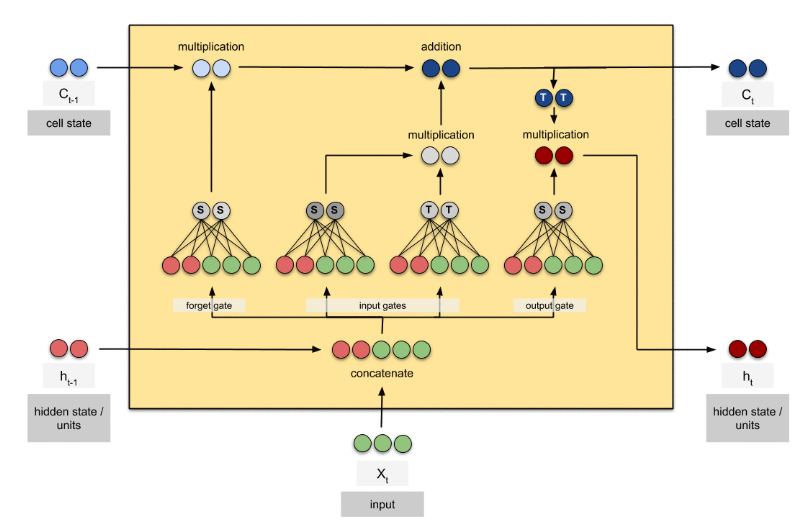

image credit: https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45

## How does a Single LSTM Unit/Cell Work? <a name="lstm_tech"></a>

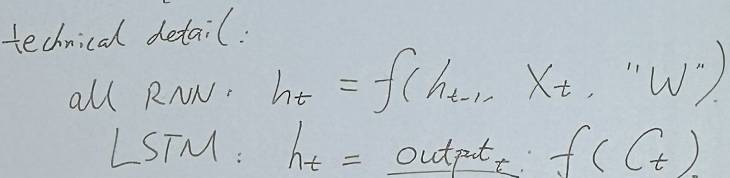
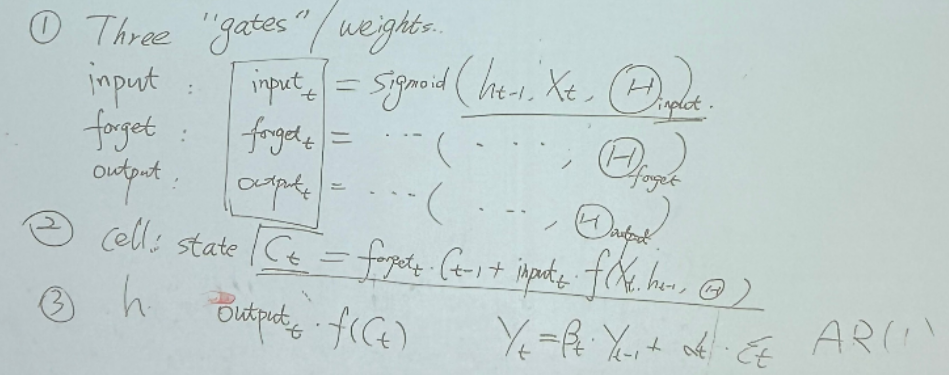

In this picture Y is equivalent to C

Here is a simplified version of how LSTM works to convey the key intuitions. A more technical description can be found [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

A LSTM unit has takes an input $X_t$, process it with a series of operations via **three "gates"** (respectively input gate, forget gate, and output gate), and then output $h_{t}$. A LSTM also has an **internal cell state**, $C_t$, which is different from the network's hidden state $h_{t-1}$.  

<font color='red'>Note that the 3 "gates" are not fixed value.</font>   
<font color='red'>All the gates are time-variant</font>
- **input gate**: $input_t = sigmoid(X_t, h_{t-1}, \Theta_{input})$ 
- **forget gate**: $forget_t = sigmoid(X_t, h_{t-1}, \Theta_{forget})$
- **output gate**: $output_t = sigmoid(X_t, h_{t-1}, \Theta_{output})$

<font color='blue'>Notice: The inner workings of the three gates are almost identical - each one applies a sigmoid function over the combination of input $X_t$ and previous hidden state $h_{t-1}$, with its own set of parameters.</font> Therefore, the best way to think about the purpose of these gates is that they act as "weights" (between 0 and 1, due to the sigmoid function).

- **Update internal cell state**: $C_t = forget_t \cdot C_{t-1} + input_t \cdot tahn(X_t, h_{t-1}, \Theta)$
    - The gates are used to update cell state

<font color='blue'>Notice: This is nothing but a weighted average!</font> The forget gate controls how much information from LSMT's previous internal state gets passed on to current internal state, and the input gate controls how much information from the new input gets passed on to current internal state. The $tahn(X_t, h_{t-1}, \Theta)$ function, on its own, is exactly the same as in the simple RNN case. This design of internal cell state also has a fancy name - "Constant Error Carousel" (CEC).

<font color="red">Question: does this remind you of anything you learned from the time series forecasting course?</font> Hint: think of $forget_t \cdot C_{t-1}$ as historical information and $input_t \cdot tahn(X_t, h_{t-1}, \Theta)$ as new information.

- **Produce output**: $h_t = output_t \cdot tahn(C_t)$
    - Then we use cell state to update the hidden state as time t

The output gate controls how much information from the updated internal state gets passed on to current hidden state.

<font color='blue'>In summary</font>, though it might seem complicated, the above steps are still trying to compute an updated hidden state $h_t$ based on the previous hidden state $h_{t-1}$ and the new input $X_t$. The three gates act like weights to control information flow, and the internal cell state _remembers_ information from the past. This is the intuition why LSTM can mitigate the vanishing gradient problem.

However, the LSTM design does not necessarily address the exploding gradient problem. It's a bit technical to explain why, and I refer you to this [blog post](https://mochenyang.github.io/mochenyangblog/machine-learning/exposition/2022/04/11/LSTM-Gradient.html) for more details if you are interested.

## Build RNN with LSTM Units in Keras <a name="lstm_implementation"></a>

In [6]:
model_lstm = keras.Sequential()

model_lstm.add(vectorize_layer)

model_lstm.add(keras.layers.Embedding(
    input_dim = len(vectorize_layer.get_vocabulary()),
    output_dim = 64,
    mask_zero = True
))

model_lstm.add(keras.layers.LSTM(128)) # dimension for hidden layers 

model_lstm.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [7]:
# configure training / optimization
model_lstm.compile(loss = keras.losses.BinaryCrossentropy(),
                   optimizer='adam',
                   metrics=['accuracy'])

In [8]:
# training with 20% validation and 10 epochs.
model_lstm.fit(x = text, y = label, validation_split = 0.2,
               epochs=10, batch_size = 32)

Epoch 1/10
75/75 [==============================] - 11s 75ms/step - loss: 0.6773 - accuracy: 0.5966 - val_loss: 0.5655 - val_accuracy: 0.7583
Epoch 2/10
75/75 [==============================] - 2s 25ms/step - loss: 0.4064 - accuracy: 0.8712 - val_loss: 0.4680 - val_accuracy: 0.7917
Epoch 3/10
75/75 [==============================] - 2s 27ms/step - loss: 0.1905 - accuracy: 0.9502 - val_loss: 0.5194 - val_accuracy: 0.7967
Epoch 4/10
75/75 [==============================] - 2s 26ms/step - loss: 0.0885 - accuracy: 0.9784 - val_loss: 0.5099 - val_accuracy: 0.8083
Epoch 5/10
75/75 [==============================] - 2s 25ms/step - loss: 0.0625 - accuracy: 0.9840 - val_loss: 0.5844 - val_accuracy: 0.8167
Epoch 6/10
75/75 [==============================] - 2s 26ms/step - loss: 0.0340 - accuracy: 0.9939 - val_loss: 0.6914 - val_accuracy: 0.8067
Epoch 7/10
75/75 [==============================] - 2s 25ms/step - loss: 0.0150 - accuracy: 0.9981 - val_loss: 0.8738 - val_accuracy: 0.7833
Epoch 8/10
7

In [36]:
# try to make some predicitons
model_lstm.predict([['I hate this meal!'], ['I love this restaurant']])

array([[0.02249685],
       [0.99999833]], dtype=float32)

In [10]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          345856    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 444,801
Trainable params: 444,801
Non-trainable params: 0
_________________________________________________________________


In [13]:
345856//64 # 5404 unique words 

5404

In [17]:
(64+128+1)*128 # +1 is ti add the bias term 

24704

In [18]:
(64+128+1)*128*4 #input gate, forget gate, output gate, Θ for cell state >> 4 learnable parameters 

98816

In [ ]:
# LSTM pays 4 times more than the original RNN 

## Suppliment: why do we need bias term? 
Neural network bias can be defined as the constant which is added to the product of features and weights.  
It is used to help the models to shift the activation function towards the positive or negative side.  

Consider the following example:  
Y = M*X + C (straight line equation)

Now if C(Bias) = 0 then, the line will always pass through the origin, i.e. (0,0), and depends on only one parameter,   
i.e. M, which is the slope so we have less things to play with.
C, which is the bias takes any number and has the activity to shift the graph, and hence able to represent more complex situations.

Source: https://stackoverflow.com/questions/2480650/what-is-the-role-of-the-bias-in-neural-networks

# Gated Recurrent Unit (GRU) Model <a name="gru"></a>

## Animated Illustration of a Single GRU <a name="gru_figure"></a>

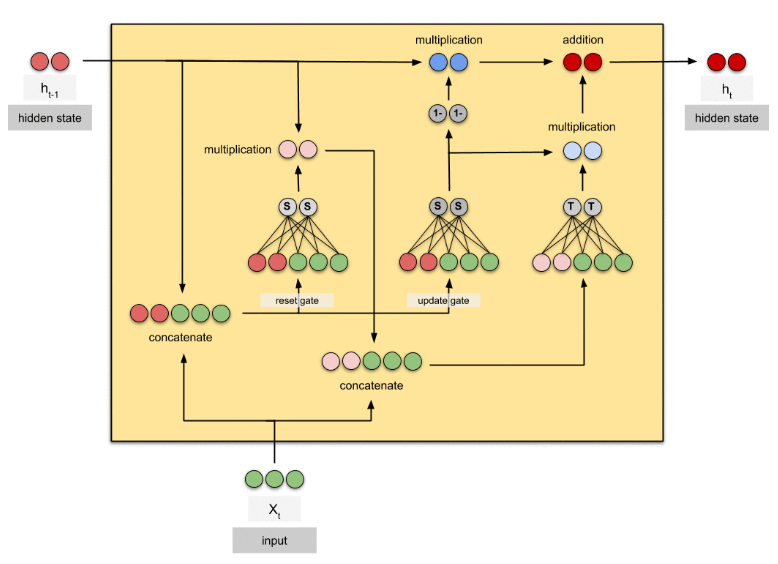

image credit: https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45

## How does a Single GRU Work? <a name="gru_tech"></a>

<font color="red">We found out that we don't need cell state so GRU is invented.</font>   
<font color="red">They have the very similar concept but GRU saves times since we don't have to compute cell state</font>
    
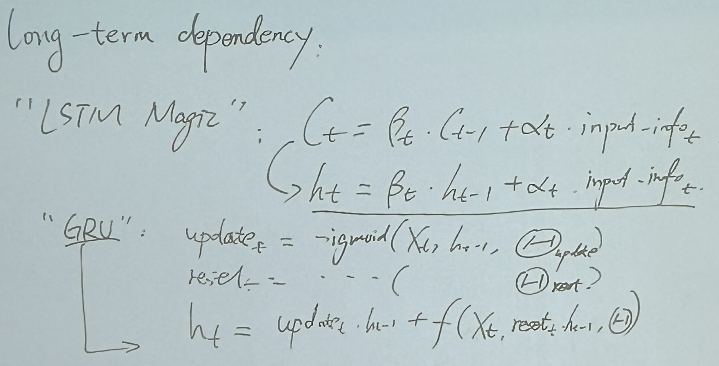

A GRU has two gates: an update gate and a reset gate. 

- **Update gate**: $update_t = sigmoid(X_t, h_{t-1}, \Theta_{update})$
- **Reset gate**: $reset_t = sigmoid(X_t, h_{t-1}, \Theta_{reset})$
- **Produce output**: $h_t = update_t \cdot h_{t-1} + (1-update_t) \cdot tahn(X_t, reset_t \cdot h_{t-1}, \Theta)$

<font color='blue'>Notice: </font> Just like in LSTM, the two gates of GRU are weights. The update gate controls how much information from previous hidden state $h_{t-1}$ gets passed on to current hidden state $h_t$, and the reset gate controls how much information from previous hidden state gets to be combined with current input $X_t$.

<font color='blue'>Interestingly</font>, even though GRU seems simpler and works basically as well as LSTM, it was proposed later than LSTM.

## Build RNN with GRUs in Keras <a name="gru_implementation"></a>

In [11]:
model_gru = keras.Sequential()

model_gru.add(vectorize_layer)

model_gru.add(keras.layers.Embedding(
    input_dim = len(vectorize_layer.get_vocabulary()),
    output_dim = 64,
    mask_zero = True
))

model_gru.add(keras.layers.GRU(128))

model_gru.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [12]:
# configure training / optimization
model_gru.compile(loss = keras.losses.BinaryCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy']) 

In [13]:
# training with 20% validation and 10 epochs.
model_gru.fit(x = text, y = label, validation_split = 0.2,
              epochs=10, batch_size = 32)

Epoch 1/10
75/75 [==============================] - 4s 31ms/step - loss: 0.6808 - accuracy: 0.5511 - val_loss: 0.5101 - val_accuracy: 0.7767
Epoch 2/10
75/75 [==============================] - 2s 22ms/step - loss: 0.3536 - accuracy: 0.8766 - val_loss: 0.4265 - val_accuracy: 0.8083
Epoch 3/10
75/75 [==============================] - 2s 22ms/step - loss: 0.1402 - accuracy: 0.9627 - val_loss: 0.4923 - val_accuracy: 0.8150
Epoch 4/10
75/75 [==============================] - 2s 22ms/step - loss: 0.0488 - accuracy: 0.9879 - val_loss: 0.5205 - val_accuracy: 0.8167
Epoch 5/10
75/75 [==============================] - 2s 22ms/step - loss: 0.0434 - accuracy: 0.9908 - val_loss: 0.5580 - val_accuracy: 0.8017
Epoch 6/10
75/75 [==============================] - 2s 22ms/step - loss: 0.0416 - accuracy: 0.9917 - val_loss: 0.6560 - val_accuracy: 0.8100
Epoch 7/10
75/75 [==============================] - 2s 21ms/step - loss: 0.0210 - accuracy: 0.9951 - val_loss: 0.9197 - val_accuracy: 0.7967
Epoch 8/10
75

In [ ]:
model_gru.summary()

# (64+128+2)*128*3
# GRU pays 3 times more than the original RNN

In [40]:
# try to make some predicitons
model_gru.predict([['I hate this meal!'], ['I love this restaurant']])

array([[0.01605341],
       [0.9999916 ]], dtype=float32)

# Bidirectional RNN Models <a name="birnn"></a>

In the context of text classification, an intuitive understanding of forward (i.e., one-directional) RNN is that it "reads" a piece of text from beginning to end, and produces a prediction. By the same analogy, a bidirectional RNN would read the text from beginning to end and also from end to beginning, then produces a prediction.

To illustrate how a bidirectional RNN works, let's consider the simple RNN units as an example. Essentially, instead of keeping one set of hidden states $h_t$ that move forward in time, a bidirectional RNN also keep another set of hidden states $g_t$ that move backward in time. Like this:
$$h_{t} = f(h_{t-1}, X_{t}, \Theta_h)$$
$$g_{t} = f(g_{t+1}, X_{t}, \Theta_g)$$

Under this general structure, you can replace the simple RNN units with LSTM or GRU, which would give rise to bi-LSTM and bi-GRU models.

Bidirectional RNN can better handling of complex input sequences by considering both the past and future context of the data.

## Building Bidirectional RNN Model in Keras <a name="birnn_implementation"></a>

Specifically, let's build a bidirectional LSTM model.

In [41]:
model_bilstm = keras.Sequential()

model_bilstm.add(vectorize_layer)

model_bilstm.add(keras.layers.Embedding(
    input_dim = len(vectorize_layer.get_vocabulary()),
    output_dim = 64,
    mask_zero = True
))

model_bilstm.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))

model_bilstm.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [42]:
# configure training / optimization
model_bilstm.compile(loss = keras.losses.BinaryCrossentropy(),
                     optimizer='adam',
                     metrics=['accuracy'])

In [43]:
# training with 20% validation and 10 epochs.
model_bilstm.fit(x = text, y = label, validation_split = 0.2,
                 epochs = 10, batch_size = 32)

Epoch 1/10
75/75 [==============================] - 7s 97ms/step - loss: 0.6309 - accuracy: 0.6704 - val_loss: 0.5082 - val_accuracy: 0.7667
Epoch 2/10
75/75 [==============================] - 3s 40ms/step - loss: 0.3136 - accuracy: 0.9008 - val_loss: 0.4528 - val_accuracy: 0.7850
Epoch 3/10
75/75 [==============================] - 3s 42ms/step - loss: 0.1349 - accuracy: 0.9621 - val_loss: 0.4401 - val_accuracy: 0.8117
Epoch 4/10
75/75 [==============================] - 3s 36ms/step - loss: 0.0757 - accuracy: 0.9808 - val_loss: 0.7320 - val_accuracy: 0.7883
Epoch 5/10
75/75 [==============================] - 3s 38ms/step - loss: 0.0476 - accuracy: 0.9871 - val_loss: 0.7814 - val_accuracy: 0.7950
Epoch 6/10
75/75 [==============================] - 3s 38ms/step - loss: 0.0322 - accuracy: 0.9908 - val_loss: 0.7875 - val_accuracy: 0.7900
Epoch 7/10
75/75 [==============================] - 3s 37ms/step - loss: 0.0205 - accuracy: 0.9954 - val_loss: 0.9245 - val_accuracy: 0.8133
Epoch 8/10
75

In [44]:
# try to make some predicitons
model_bilstm.predict([['I hate this meal!'], ['I love this restaurant']])

array([[0.00192887],
       [0.9999987 ]], dtype=float32)

# Additional Resources <a name="resources"></a>

- LSTM paper: [LSTM: A Search Space Odyssey](https://arxiv.org/pdf/1503.04069.pdf?fbclid=IwAR377Jhphz_xGSSThcqGUlAx8OJc_gU6Zwq8dABHOdS4WNOPRXA5LcHOjUg)
- GRU paper: [On the Properties of Neural Machine Translation: Encoder-Decoder Approaches](https://arxiv.org/pdf/1409.1259.pdf)